In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display, Image
import ipywidgets
import numpy
import pandas
from matplotlib import cm, pyplot

import calibr8
import dataloading
import models
import plotting

You are running the v4 development version of PyMC3 which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc3/tree/v3


### Read the data

In [3]:
df_layout = dataloading.get_layout("layout.xlsx")
df_time, df_A360, df_A600 = dataloading.vectorize_observations(
    df_layout,
    observations={
         "20210614": (
             dataloading.read_absorbances("Placeholder_Absorbance_360nm.csv"),
             dataloading.read_absorbances("Placeholder_Absorbance_600nm.csv"),
         )
    }
)

display(df_layout.head())
display(df_A360.head())

No 'replicate_id' column found. Generating hagelhashes from run+assay_well.


,run,assay_well,reactor,group,product,biomass
replicate_id,,,,,,
86CH7,20210614,A01,A1,Reactor,NaN,NaN
P9DK9,20210614,A02,A2,Reactor,NaN,NaN
76Z3F,20210614,A10,A10,cal_0,0.0,NaN
XA4K1,20210614,A11,A11,cal_0,0.0,NaN
W9T1R,20210614,A12,A12,cal_0,0.0,NaN


cycle,0,1,2,3,4
replicate_id,,,,,
86CH7,1.141,1.605,1.892,1.963,2.276
P9DK9,1.152,1.702,1.958,2.009,2.219
76Z3F,1.037,1.037,1.085,1.176,1.252
XA4K1,1.033,1.050,1.094,1.190,1.245
W9T1R,1.048,1.054,1.101,1.176,1.274


In [4]:
def plot_content(group: str):
    fig, axs = pyplot.subplots(ncols=2, figsize=(12, 4), dpi=140, sharex=True)

    rids = df_layout[df_layout["group"] == group].index
    ax = axs[0]
    ax.plot(df_time.loc[rids].T, df_A360.loc[rids].T, label="360 nm")
    ax.set(
        ylabel="absorbance at 360 mm",
        xlabel="time   [h]",
        ylim=(0, 2.5),
    )

    ax = axs[1]
    ax.plot(df_time.loc[rids].T, df_A600.loc[rids].T, label="600 nm")
    ax.set(
        ylabel="absorbance at 600 mm",
        xlabel="time   [h]",
        ylim=(0, 1),
        xlim=(0, None),
    )
    fig.tight_layout()
    pyplot.show()
    
ipywidgets.interact(
    plot_content,
    group=numpy.unique(df_layout["group"].dropna())
);

interactive(children=(Dropdown(description='group', options=('Reactor', 'cal_0', 'cal_1', 'cal_2', 'cal_3', 'c…

### Empirical observations to motivate further analyses

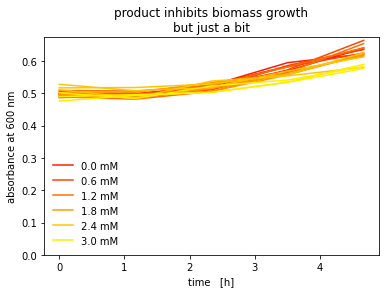

In [5]:
plotting.plot_calibration_biomass_observations(df_layout, df_A600, df_time)

### Prepare calibration models

Because we don't have a proper biomass calibration, well assume some proportionalities:

$$A_{600} \propto X$$
$$A_{360} \propto X$$

In [6]:
calibration_rids = df_layout[~df_layout["product"].isna()].index
df_rel_biomass = (df_A600.loc[calibration_rids].T / df_A600.loc[calibration_rids, 0]).T
df_rel_biomass

cycle,0,1,2,3,4
replicate_id,,,,,
76Z3F,1.0,0.993976,1.056225,1.172691,1.277108
XA4K1,1.0,1.010267,1.078029,1.221766,1.277207
W9T1R,1.0,1.002008,1.050201,1.144578,1.287149
CMHMH,1.0,1.006048,1.030242,1.155242,1.338710
CWA8E,1.0,0.978261,1.039526,1.150198,1.235178
D8MME,1.0,0.972000,1.026000,1.172000,1.274000
BF9DD,1.0,0.985685,1.034765,1.157464,1.259714
LYK8N,1.0,1.006098,1.052846,1.148374,1.329268
7F853,1.0,0.996071,1.031434,1.143418,1.259332


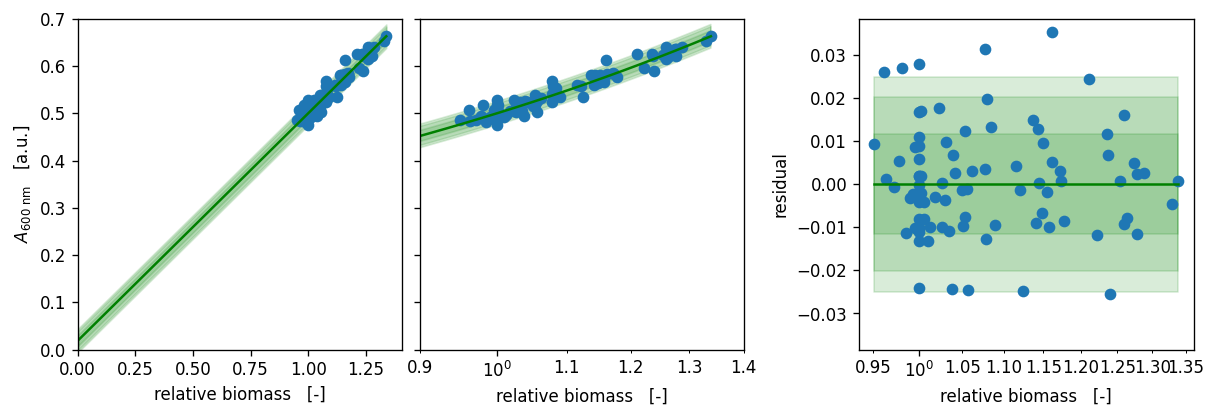

In [7]:
cm_600 = models.LinearBiomassAbsorbanceModel(independent_key="X", dependent_key="A600")
calibr8.fit_scipy(
    cm_600,
    independent=df_rel_biomass.to_numpy().flatten(),
    dependent=df_A600.loc[calibration_rids].to_numpy().flatten(),
    theta_guess=[0.5, 0, 0.2, 3],
    theta_bounds=[
        (0, 2),      # intercept
        (-0.5, 0.5), # slope
        (0.01, 1),   # scale
        (1, 30),     # degree of freedom
    ]
)

plotting.plot_cmodel(cm_600)
cm_600.save("calibration_A600.json")

### Plots to make informed guesses about A360/X and A360/P relationships

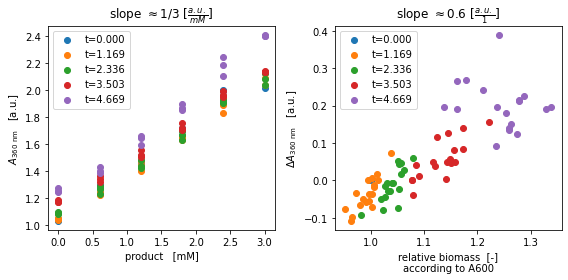

In [8]:
plotting.plot_A360_relationships(df_layout, df_time, df_A360, df_rel_biomass, calibration_rids)

In [9]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Oct 05 2021

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.22.0

calibr8   : 6.0.3
pandas    : 1.3.0
ipywidgets: 7.6.3
matplotlib: 3.4.2
numpy     : 1.21.0

Watermark: 2.2.0

